# Grid-scale atmospheric moisture and mass budgets in ERA5 pressure level data

In [1]:
import numpy as np
import xarray as xr

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

Files: ERA5 pressure level data from `1979-01-01T00 - 1979-01-01T12`

* `/glade/derecho/scratch/ksha/CREDIT_data/ERA5_pressure_lev/upper_air_test.zarr`
* `/glade/derecho/scratch/ksha/CREDIT_data/ERA5_pressure_lev/surf_test.zarr`

In [3]:
ds_upper = xr.open_zarr('/glade/derecho/scratch/ksha/CREDIT_data/ERA5_pressure_lev/upper_air_test.zarr')
ds_surf = xr.open_zarr('/glade/derecho/scratch/ksha/CREDIT_data/ERA5_pressure_lev/surf_test.zarr')

In [4]:
GRAVITY = 9.80665
R = 6371000  # m

In [5]:
x = ds_surf['longitude']
y = ds_surf['latitude']
lon, lat = np.meshgrid(x, y)
level_p = 100*np.array(ds_upper['level'])

In [6]:
level_p # Pa or kg/m/s2

array([   100,    200,    300,    500,    700,   1000,   2000,   3000,
         5000,   7000,  10000,  12500,  15000,  17500,  20000,  22500,
        25000,  30000,  35000,  40000,  45000,  50000,  55000,  60000,
        65000,  70000,  75000,  77500,  80000,  82500,  85000,  87500,
        90000,  92500,  95000,  97500, 100000])

In [7]:
q = np.array(ds_upper['specific_humidity']) # kg/kg
u = np.array(ds_upper['u_component_of_wind']) # m/s
v = np.array(ds_upper['v_component_of_wind'])

In [8]:
# def dx_dy(lat, lon):
#     '''
#     Compute the grid spacing from 2D lat/lon grids

#     Args:
#         lat, lon: latitude and longitude with dims of (lat, lon)

#     Return:
#         grid spacings as dy, dx, dims are (lat, lon)
#     '''
#     # Convert latitude and longitude from degrees to radians
#     lat_rad = np.radians(lat)
#     lon_rad = np.radians(lon)
    
#     # Calculate the grid spacings in the latitude and longitude directions
#     dy = R * np.gradient(lat_rad, axis=0)
#     dx = R * np.cos(lat_rad) * np.gradient(lon_rad, axis=1)

#     return dy, dx

def dx_dy(lat, lon):
    '''
    Compute the grid spacing from 2D lat/lon grids using central difference
    for center grids and forward/backward difference for edge grids

    Args:
        lat, lon: 2D arrays of latitude and longitude.

    Return:
        dy, dx: 2D arrays of grid spacings
    '''
    
    # Convert latitude and longitude from degrees to radians
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    
    # Compute the grid spacing in the latitude direction (dy)
    dy = np.zeros_like(lat)
    dy[1:-1, :] = R * (lat_rad[2:, :] - lat_rad[:-2, :]) / 2.0
    dy[0, :] = R * (lat_rad[1, :] - lat_rad[0, :])
    dy[-1, :] = R * (lat_rad[-1, :] - lat_rad[-2, :])
    
    # Compute the grid spacing in the longitude direction (dx)
    dx = np.zeros_like(lon)
    dx[:, 1:-1] = R * np.cos(lat_rad[:, 1:-1]) * (lon_rad[:, 2:] - lon_rad[:, :-2]) / 2.0
    dx[:, 0] = R * np.cos(lat_rad[:, 0]) * (lon_rad[:, 1] - lon_rad[:, 0])
    dx[:, -1] = R * np.cos(lat_rad[:, -1]) * (lon_rad[:, -1] - lon_rad[:, -2])

    return dy, dx

def Poisson_FDM(f, dx, dy, max_iterations=1000, tolerance=1e-5, omega=1.0):
    '''
    Poisson equation solver using the Finite Difference Method (FDM).

    \nabla^2 E = f
    
    Args:
        f: 2D scalar input, i.e., the laplacian of E
        dx, dy: grid spacings of f
        max_iterations: max number of iterations
        tolerance: FDM epsilon
        omega: SOR factor, 1.0 means no SOR, larger than 1.0 uses SOR
        
    Returns:
        E: scalar potential
        
    '''
    ny, nx = f.shape
    E = np.zeros((ny, nx))
    
    for iteration in range(max_iterations):
        E_new = np.copy(E)
        
        dx_avg = (dx[1:-1, 1:-1] + dx[1:-1, 2:]) / 2
        dy_avg = (dy[1:-1, 1:-1] + dy[2:, 1:-1]) / 2
        
        dy_avg2 = dy_avg**2
        dx_avg2 = dx_avg**2
        
        # Corrected denom calculation
        denom = 2/dx_avg2 + 2/dy_avg2
        
        E_new[1:-1, 1:-1] = (1 - omega) * E[1:-1, 1:-1] + omega * (
            (E[2:, 1:-1] + E[:-2, 1:-1]) / dy_avg2 +
            (E[1:-1, 2:] + E[1:-1, :-2]) / dx_avg2 -
            f[1:-1, 1:-1]
        ) / denom
        
        E_new[0, :] = E_new[-1, :] = E_new[:, 0] = E_new[:, -1] = 0
        
        if np.max(np.abs(E_new - E)) < tolerance:
            print(f'Converged after {iteration+1} iterations.')
            break
        
        E = E_new
    
    return E

def compute_gradient_2d(E, lat, lon):
    '''
    Compute the gradient of a 2D scalar quantity using central difference
    for center grids and forward/backward difference for edge grids

    Args:
        E: the 2D scalar quantity
        lat, lon: latitude and longitude with dims of (lat, lon)

    Return:
        Gradients as dEdy, dEdx
    '''
    dy, dx = dx_dy(lat, lon)
    # Use second-order central differencing in the interior, and forward/backward at the boundaries
    dEdy = np.zeros_like(E)
    dEdx = np.zeros_like(E)
    
    # Central differencing in the interior (higher order)
    dEdy[1:-1, :] = (E[2:, :] - E[:-2, :]) / (dy[1:-1, :] + dy[:-2, :])
    dEdx[:, 1:-1] = (E[:, 2:] - E[:, :-2]) / (dx[:, 1:-1] + dx[:, :-2])

    # Forward differencing at the first row (North boundary)
    dEdy[0, :] = (E[1, :] - E[0, :]) / dy[0, :]
    # Backward differencing at the last row (South boundary)
    dEdy[-1, :] = (E[-1, :] - E[-2, :]) / dy[-1, :]

    # Forward differencing at the first column (Prime meridian)
    dEdx[:, 0] = (E[:, 1] - E[:, 0]) / dx[:, 0]
    # Backward differencing at the last column (International Date Line)
    dEdx[:, -1] = (E[:, -1] - E[:, -2]) / dx[:, -1]
    
    return dEdy, dEdx

def compute_divergence(u, v, lat, lon):
    '''
    Compute the divergence of 2D vectors.

    Args:
        u, v: the 2D vector
        lat, lon: latitude and longitude with dims of (lat, lon)

    Return:
        divergence
    '''
    dy, dx = dx_dy(lat, lon)
    
    # Compute the partial derivatives along latitude and longitude, maintaining the time dimension
    dvdy = np.gradient(v, axis=-2) / dy  # Gradient along latitude
    dudx = np.gradient(u, axis=-1) / dx  # Gradient along longitude
    
    # Total divergence
    divergence = dudx + dvdy
    
    return divergence

def pressure_integral(q, level_p, output_shape):
    
    # (level, lat, lon) --> (lat, lon)
    if len(output_shape) == 2:
        Q = np.empty(output_shape)
        for ix in range(output_shape[0]):
            for iy in range(output_shape[1]):
                Q[ix, iy] = np.trapz(q[:, ix, iy], level_p)
                
    # (time, level, lat, lon) --> (time, lat, lon)
    elif len(output_shape) == 3:
        Q = np.empty(output_shape)
        for i_time in range(output_shape[0]):
            for ix in range(output_shape[1]):
                for iy in range(output_shape[2]):
                    Q[i_time, ix, iy] = np.trapz(q[i_time, :, ix, iy], level_p)
                    
    else:
        print('wrong output_shape')
        raise
        
    return Q

In [9]:
def weighted_sum(data, weights, axis, keepdims=False):
    '''
    Compute the weighted sum of a given quantity

    Args:
        data: the quantity to be sum-ed
        weights: weights that can be broadcasted to the shape of data
        axis: dims to compute the sum
        keepdims: keepdims

    Returns:
        weighted sum
    '''
    expanded_weights = np.broadcast_to(weights, data.shape)
    return np.sum(data * expanded_weights, axis=axis, keepdims=keepdims)

def compute_grid_area(lat, lon):
    '''
    Compute grid cell areas from 2D lat/lon grids

    Args:
        lat, lon: latitude and longitude with dims of (lat, lon)

    Return:
        grid cell area, dims are (lat, lon)
    '''
    dy, dx = dx_dy(lat, lon)
    area = dy*dx

    return area

area = compute_grid_area(lat, lon)

# w_lat = np.cos(np.deg2rad(lat))
w_lat = area #/ np.sum(area)

In [10]:
dy, dx = dx_dy(lat, lon)

## Conservation of total dry air mass

Reference:
* [Trenberth and Fasullo (2018)](https://doi.org/10.1175/JCLI-D-17-0838.1)
* [Trenberth (1991)](https://doi.org/10.1175/1520-0442(1991)004<0707:CDFGAC>2.0.CO;2)
* [ERA5 documentation](
https://confluence.ecmwf.int/display/CKB/Mass-consistent+atmospheric+energy+and+moisture+budget+data+from+1979+to+present+derived+from+ERA5+reanalysis%3A+Product+User+Guide)

Equation on a single air column (flux form equation with unit of kg/m^2/s):

\begin{equation}
\mathbf{\nabla} \cdot \frac{1}{g} \int_{0}^{p_s}{\left[\left(1-q\right)\mathbf{v}\right]}dp + \frac{1}{g}\frac{\partial}{\partial t}\int_{0}^{p_s}{\left(1-q\right)}dp = 0
\end{equation}

If the budget cannot be closed on each grid cell, a residual term $e$ would exist:

\begin{equation}
\mathbf{\nabla} \cdot \frac{1}{g} \int_{p_0}^{p_1}{\left[\left(1-q\right)\mathbf{v}\right]}dp + \frac{1}{g}\frac{\partial}{\partial t}\int_{p_0}^{p_1}{\left(1-q\right)}dp = e
\end{equation}

### Adjust $\mathbf{v}$ to close the budget

Horizontal winds $\mathbf{v}$ can be corrected using residuals:

* Step1: find $E$ that satisfies $\nabla^2 E = e$ by solving Poisson eqution.

\begin{equation}
E = \nabla^{-2} e
\end{equation}

* Step2: compute the residual wind $\mathbf{v}_c$

\begin{equation}
\mathbf{v}_c = \mathbf{\nabla} E 
\end{equation}

* Step3: apply barotropic wind correction:

\begin{equation}
\mathbf{v}_*\left(l, x, y\right) = \mathbf{v}\left(l, x, y\right) + \frac{\mathbf{v}_c\left(x, y\right)}{\Delta p}
\end{equation}

* Step4: replace $\mathbf{v}$ with $\mathbf{v}_*$ and do the correction again (iterative)

### Adjust $q$ to close the budget 

Iterative correction using gradient descent:

\begin{equation}
q^* = q - \alpha\frac{e}{q}
\end{equation}

### Method 1: $\mathbf{v}$ correction

In [11]:
t0 = 0
t1 = 1

# ??
# use the divergence of mass flux on t0 (or t1) to compare against the pressure tendency from t0 to t1
tc = t0

output_shape = (2,)+lon.shape

In [12]:
# compute tendency
mass_dry_per_area = pressure_integral(1-q, level_p, output_shape) / GRAVITY # kg/m^2
dm_dt = (mass_dry_per_area[t1, ...] - mass_dry_per_area[t0, ...]) / 3600

In [13]:
u_correct = np.copy(u[tc, ...]) # <-- corrected u, v
v_correct = np.copy(v[tc, ...])

correction_cycle_num = 1

for i in range(correction_cycle_num):

    Fx_dry = u_correct*(1-q[tc, ...])
    Fy_dry = v_correct*(1-q[tc, ...])

    Fx_dry_int = pressure_integral(Fx_dry, level_p, output_shape[1:]) / GRAVITY
    Fy_dry_int = pressure_integral(Fy_dry, level_p, output_shape[1:]) / GRAVITY
    
    div_mass = compute_divergence(Fx_dry_int, Fy_dry_int, lat, lon) # kg/m2/s
    residual_mass = div_mass + dm_dt

    print('Global sum of mass flux divergence [kg/s] {}, should be 0.0'.format(weighted_sum(div_mass, w_lat, axis=(0, 1))))
    print('Global sum of residual mass flux [kg/s]: {}, should be 0.0'.format(weighted_sum(residual_mass, w_lat, axis=(0, 1))))
    # ------------------------------------ #
    # Poisson solver
    Chi = Poisson_FDM(residual_mass, dx, dy, max_iterations=1000, tolerance=1e-3, omega=1.0)
    # ------------------------------------ #
    res_v, res_u = compute_gradient_2d(Chi, lat, lon)
    
    print('Correction iter {}'.format(i))
    
    u_correct = u_correct - res_u/(level_p[-1] - level_p[0])
    v_correct = v_correct - res_v/(level_p[-1] - level_p[0])

# ----------------------------------- #
Fx_dry = u_correct*(1-q[tc, ...])
Fy_dry = v_correct*(1-q[tc, ...])

Fx_dry_int = pressure_integral(Fx_dry, level_p, output_shape[1:]) / GRAVITY
Fy_dry_int = pressure_integral(Fy_dry, level_p, output_shape[1:]) / GRAVITY

div_mass = compute_divergence(Fx_dry_int, Fy_dry_int, lat, lon) # kg/m2/s
residual_mass = div_mass + dm_dt

print('Global sum of mass flux divergence [kg/s] {}, should be 0.0'.format(weighted_sum(div_mass, w_lat, axis=(0, 1))))
print('Global sum of residual mass flux [kg/s]: {}, should be 0.0'.format(weighted_sum(residual_mass, w_lat, axis=(0, 1))))

Global sum of mass flux divergence [kg/s] 10398039565.272814, should be 0.0
Global sum of residual mass flux [kg/s]: 9942272077.22546, should be 0.0
Correction iter 0
Global sum of mass flux divergence [kg/s] 1808288834.4807718, should be 0.0
Global sum of residual mass flux [kg/s]: 1352521346.4334064, should be 0.0


Text(0.5, 1.0, 'original 1000 hPa u')

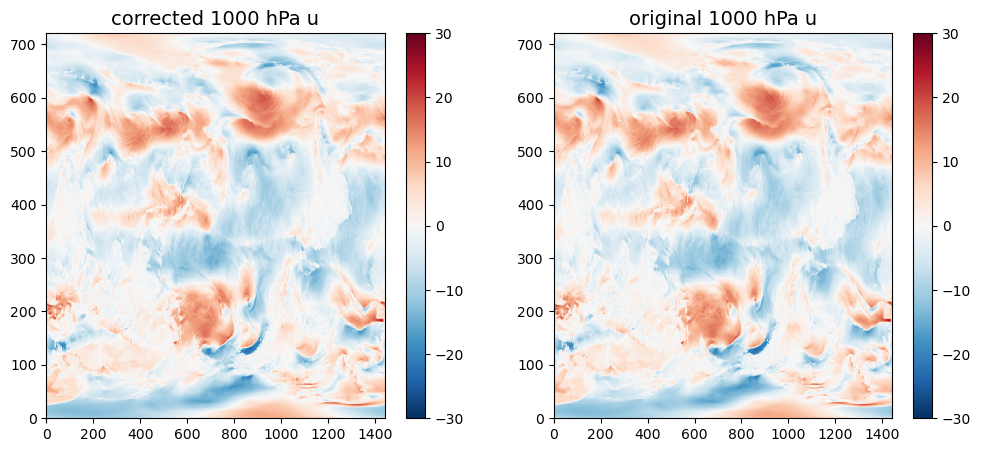

In [14]:
# Plot the original source term f and the calculated Laplacian to compare
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pcolormesh(u_correct[-1, ...], vmin=-30, vmax=30, cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.title('corrected 1000 hPa u', fontsize=14)

plt.subplot(1, 2, 2)
plt.pcolormesh(u[tc, -1, ...], vmin=-30, vmax=30, cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.title('original 1000 hPa u', fontsize=14)

### Method 2: $q$ correction (x)

In [15]:
t0 = 0
t1 = 1

# ??
# use the divergence of mass flux on t0 (or t1) to compare against the pressure tendency from t0 to t1
tc = t0

output_shape = (2,)+lon.shape

In [16]:
# compute tendency
mass_dry_per_area = pressure_integral(1-q, level_p, output_shape) / GRAVITY # kg/m^2
dm_dt = (mass_dry_per_area[t1, ...] - mass_dry_per_area[t0, ...]) / 3600

## Moisture budget

Reference
* [Mayer et al. (2021)](https://doi.org/10.1175/JCLI-D-20-0676.1)
* [Seager and Henderson (2013)](https://doi.org/10.1175/JCLI-D-13-00018.1)

Equation
\begin{equation}
\mathbf{\nabla} \cdot \frac{1}{g} \int_{0}^{p_s}{\left(\mathbf{v}q\right)}dp = -\frac{1}{g}\frac{\partial}{\partial t}\int_{0}^{p_s}{q}dp - E - P
\end{equation}